Read two documents and integrate data using 'parent_asin'. Select 11 variables and filter for the "Appliances" category from all classes. Additionally, select only reviews with verified payments to avoid fake reviews.

In [ ]:
!pip install pandas scikit-learn nltk
!pip install scikit-learn sentence_transformers pandas numpy
!pip install -U sentence-transformers
!pip install -U scikit-learn

In [ ]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
import pandas as pd

# Initialize the model
model = SentenceTransformer("all-MiniLM-L6-v2")

verified_review = pd.read_csv("pre_progress_data.csv")
characteristics = {
    "Described": ["described"],
    "Brand": ["brand"],
    "Price": ["price", "value", "purchase", "expensive"],
    "Install & Replace": ["install", "part", "replacement", "replace"],
    "Delivery": ["delivery", "fast"],
    "Design": ["look", "light", "looking"],
    "Size": ["fit", "exact", "original", "small", "size", "little"],
    "Performance": ["use", "work", "quiet", "worked"],
    "Service": ["service", "issue"],
    "Quality": ["quality"],
    "Emotion": ["perfect", "perfectly", "great", "love", "well", "expected", "needed", "nice", "happy", "good", "like"]
}

# Create a list of all characteristic phrases
all_phrases = [phrase for phrases in characteristics.values() for phrase in phrases]

verified_review['text'] = verified_review['text'].astype(str)
# Compute embeddings for document sentences and characteristic phrases
document_sentences = verified_review['text'].tolist()
document_embeddings = model.encode(document_sentences)
phrase_embeddings = model.encode(all_phrases)

# Compute cosine similarities
similarities = util.pytorch_cos_sim(document_embeddings, phrase_embeddings).numpy()

# Output the pairs with their score
for idx_i, sentence in enumerate(document_sentences):
    print(f"Document Sentence: '{sentence}'")
    for characteristic, phrases in characteristics.items():
        # Get the indices of the phrases corresponding to the current characteristic
        phrase_indices = [all_phrases.index(phrase) for phrase in phrases]
        # Get the maximum similarity score for the current characteristic
        max_similarity = max(similarities[idx_i][phrase_indices])
        print(f" - Characteristic '{characteristic}': {max_similarity:.4f}")
    print()


流式输出内容被截断，只能显示最后 5000 行内容。
 - Characteristic 'Delivery': 0.0521
 - Characteristic 'Design': 0.1216
 - Characteristic 'Size': 0.0948
 - Characteristic 'Performance': 0.0409
 - Characteristic 'Service': 0.0561
 - Characteristic 'Quality': 0.1109
 - Characteristic 'Emotion': 0.0729

Document Sentence: 'Nothing'
 - Characteristic 'Described': 0.2651
 - Characteristic 'Brand': 0.1876
 - Characteristic 'Price': 0.3304
 - Characteristic 'Install & Replace': 0.2245
 - Characteristic 'Delivery': 0.3336
 - Characteristic 'Design': 0.3866
 - Characteristic 'Size': 0.3518
 - Characteristic 'Performance': 0.4380
 - Characteristic 'Service': 0.3222
 - Characteristic 'Quality': 0.2873
 - Characteristic 'Emotion': 0.3358

Document Sentence: 'Filters were exactly what I needed.  They were bent in delivery but will keep them as I appreciate the items as perfect!'
 - Characteristic 'Described': 0.0639
 - Characteristic 'Brand': 0.1387
 - Characteristic 'Price': 0.0719
 - Characteristic 'Install & Replace

In [ ]:
from transformers import pipeline
import torch
from transformers import pipeline, BertTokenizer

# Ensure you are running on GPU if available
device = 0 if torch.cuda.is_available() else -1

# Initialize sentiment analysis pipeline with a specific model
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", device=device)
tokenizer = BertTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:

# Define similarity threshold
similarity_threshold = 0.2

# Collect results in a list
results = []

# Output the pairs with their score and sentiment
for idx, sentence in enumerate(document_sentences):
    print(f"Document Sentence: {sentence}")
    max_similarity = 0
    best_characteristic = None

    for characteristic, phrases in characteristics.items():
        phrase_indices = [all_phrases.index(phrase) for phrase in phrases]
        current_max_similarity = max(similarities[idx, phrase_indices])

        if current_max_similarity > max_similarity:
            max_similarity = current_max_similarity
            best_characteristic = characteristic

    if max_similarity > similarity_threshold:
        # Tokenize the sentence to check its length
        tokens = tokenizer.encode(sentence, truncation=True,max_length=500)
        truncated_sentence = tokenizer.decode(tokens)
        # Get the sentiment
        sentiment = sentiment_pipeline(truncated_sentence)
        sentiment_label = sentiment[0]['label']
        sentiment_score = sentiment[0]['score']

        # Determine the polarity of the sentiment
        if sentiment_label in ['1 star', '2 stars']:
            sentiment_polarity = 'negative'
        elif sentiment_label in ['4 stars', '5 stars']:
            sentiment_polarity = 'positive'
        else:
            sentiment_polarity = 'neutral'

    # Append the results to the list
    results.append({
        'Sentence': sentence,
        'Characteristic': best_characteristic,
        'Characteristic Score': max_similarity,
        'Sentiment Polarity': sentiment_polarity,
        'Stars': sentiment_label,
        'Sentiment Score': sentiment_score
    })

# Convert the results list to a DataFrame
final_data = pd.DataFrame(results)

#print(f" - Characteristic '{best_characteristic}': {max_similarity:.4f}, sentiment polarity: {sentiment_polarity} ({sentiment_label} {sentiment_score:.4f})")


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


流式输出内容被截断，只能显示最后 5000 行内容。
Document Sentence: This product melted the first time that the oven was used.
Document Sentence: It fit! I was very pleased that not only did the product fit but it was sturdy, made of good quality.
Document Sentence: Exact replacement.  Works perfectly.
Document Sentence: Works great!
Document Sentence: Install into a custom hood range was pretty easy. I had to make some adjustments to the ductwork due to some attic clearance issues, but it mated up tightly.  I don't think we've ever used the highest setting on this since low and medium seem to do what we need.
Document Sentence: Replacement bin is exactly what we wanted.
Document Sentence: Works just too expensive
Document Sentence: It was an exact replacement
Document Sentence: Large burner barely would light and stay lit. Vendor gave full refund though. Thank you.
Document Sentence: Don't buy unless you like regrets
Document Sentence: Delivered as expected, worked just fine.
Document Sentence: Product and

In [ ]:
verified_review = verified_review.reset_index(drop=True)
final_data = final_data.reset_index(drop=True)
df_all = pd.concat([verified_review, final_data], axis=1)

In [ ]:
df_all.to_csv('df_all_M1.csv', index=False)

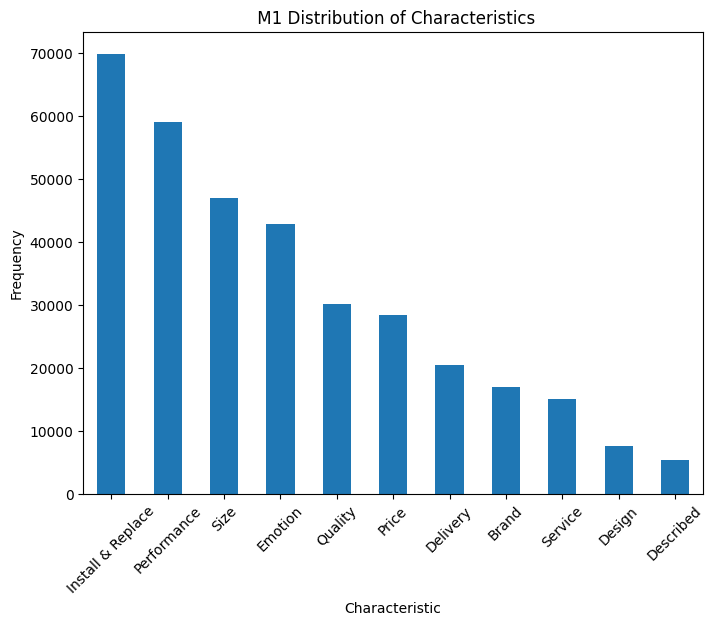

In [ ]:
df_all = pd.read_csv('df_all_M1.csv')
import matplotlib.pyplot as plt
# Plot 1: Distribution of Characteristics
plt.figure(figsize=(8, 6))
df_all['Characteristic'].value_counts().plot(kind='bar')
plt.title(' M1 Distribution of Characteristics')
plt.xlabel('Characteristic')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

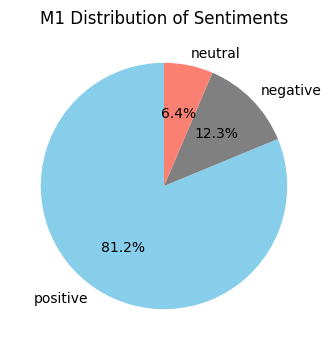

In [ ]:
# Load data
import pandas as pd
import matplotlib.pyplot as plt

# Create a pie chart for the sentiment polarity distribution with specific colors
colors = ['skyblue', 'gray','salmon']  # Colors corresponding to positive, neutral, and negative sentiments
plt.figure(figsize=(6, 4))
df_all['Sentiment Polarity'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('M1 Distribution of Sentiments')
plt.ylabel('')  # Hide the y-label as it's not needed for pie charts
plt.show()

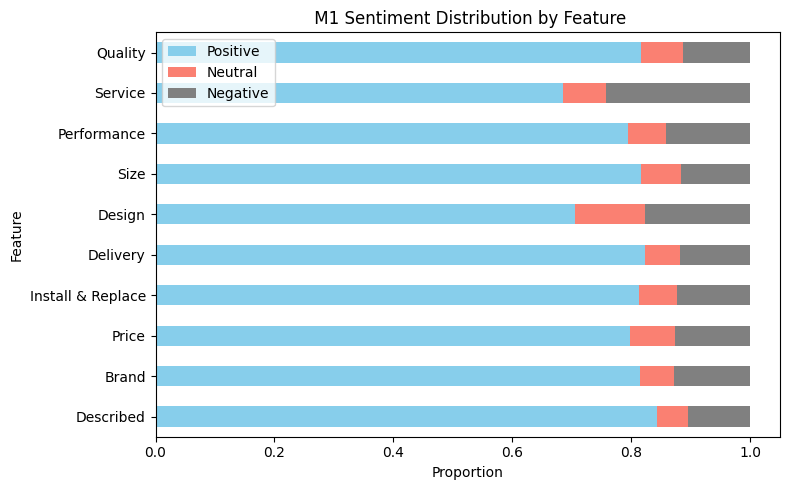

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data


# Clean data
df_all['Sentiment Polarity'] = df_all['Sentiment Polarity'].str.strip()
df_all['Stars'] = df_all['Stars'].str.strip()
df_all['Sentiment Score'] = df_all['Sentiment Score'].astype(float)
df_all['Characteristic Score'] = df_all['Characteristic Score'].astype(float)
df_all['Characteristic'] = df_all['Characteristic'].str.strip()

# Map sentiment to labels for visualization
df_all['label'] = df_all['Sentiment Polarity'].map({'positive': 0, 'neutral': 1, 'negative': 2})

# Feature list
features = [
    'Described',
    'Brand',
    'Price',
    'Install & Replace',
    'Delivery',
    'Design',
    'Size',
    'Performance',
    'Service',
    'Quality',
]

# Prepare figure layout
fig, ax = plt.subplots(figsize=(8, 5))

# Initialize an empty DataFrame to store sentiment data for each feature
sentiment_data = pd.DataFrame()

for feature in features:
    subset = df_all[df_all['Characteristic'] == feature]
    sentiment_distribution = subset['Sentiment Polarity'].value_counts(normalize=True)
    sentiment_distribution = sentiment_distribution.reindex(['positive', 'neutral', 'negative'], fill_value=0)
    sentiment_data = pd.concat([sentiment_data, sentiment_distribution.to_frame().T])

# Set the feature names as the index
sentiment_data.index = features

# Plotting
sentiment_data.plot(kind='barh', stacked=True, ax=ax, color=['skyblue', 'salmon', 'gray'])
ax.set_xlabel('Proportion')
ax.set_ylabel('Feature')
ax.set_title(' M1 Sentiment Distribution by Feature')
plt.legend(['Positive', 'Neutral', 'Negative'])
plt.tight_layout()
plt.show()


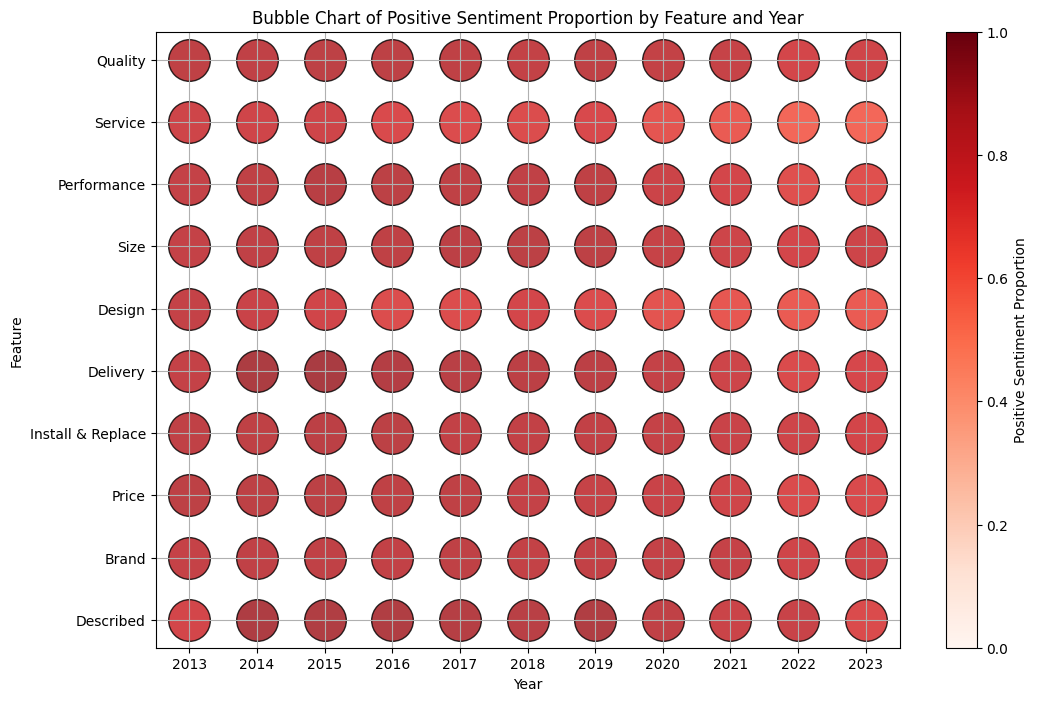

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Assuming the data is loaded into df_all


# Clean data
df_all['Sentiment Polarity'] = df_all['Sentiment Polarity'].str.strip()
df_all['Stars'] = df_all['Stars'].str.strip()
df_all['Sentiment Score'] = df_all['Sentiment Score'].astype(float)
df_all['Characteristic Score'] = df_all['Characteristic Score'].astype(float)
df_all['Characteristic'] = df_all['Characteristic'].str.strip()

# Ensure timestamp column is datetime type, and extract year
df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
df_all['year'] = df_all['timestamp'].dt.year

# Map sentiment to a binary label for calculating proportions (1 for positive, 0 otherwise)
df_all['label'] = df_all['Sentiment Polarity'].apply(lambda x: 1 if x == 'positive' else 0)

# Feature list
features = [
    'Described',
    'Brand',
    'Price',
    'Install & Replace',
    'Delivery',
    'Design',
    'Size',
    'Performance',
    'Service',
    'Quality'
]

# Calculate the proportion of positive sentiment per feature per year
bab_data = pd.DataFrame(index=features, columns=np.sort(df_all['year'].unique()))

# Fill bab_data DataFrame
for year in bab_data.columns:
    for feature in bab_data.index:
        if df_all[(df_all['year'] == year) & (df_all['Characteristic'] == feature)]['label'].count() > 0:
            bab_data.loc[feature, year] = df_all[(df_all['year'] == year) & (df_all['Characteristic'] == feature)]['label'].mean()
        else:
            bab_data.loc[feature, year] = 0

# Create a color map for visualization
cmap = plt.cm.Reds  # You can change the color map to any you prefer

# Normalize the color map based on the proportion values
norm = mcolors.Normalize(vmin=0, vmax=1)

# Create a bubble chart
fig, ax = plt.subplots(figsize=(12, 8))
for feature in bab_data.index:
    for year in bab_data.columns:
        proportion = bab_data.loc[feature, year]
        color = cmap(norm(proportion))
        ax.scatter(year, feature, color=color, s=900, alpha=0.8, edgecolors='black')  # Fixed size

ax.set_xlabel('Year')
ax.set_ylabel('Feature')
ax.set_title('Bubble Chart of Positive Sentiment Proportion by Feature and Year')
ax.grid(True)
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', label='Positive Sentiment Proportion')
plt.xticks(bab_data.columns)
plt.show()

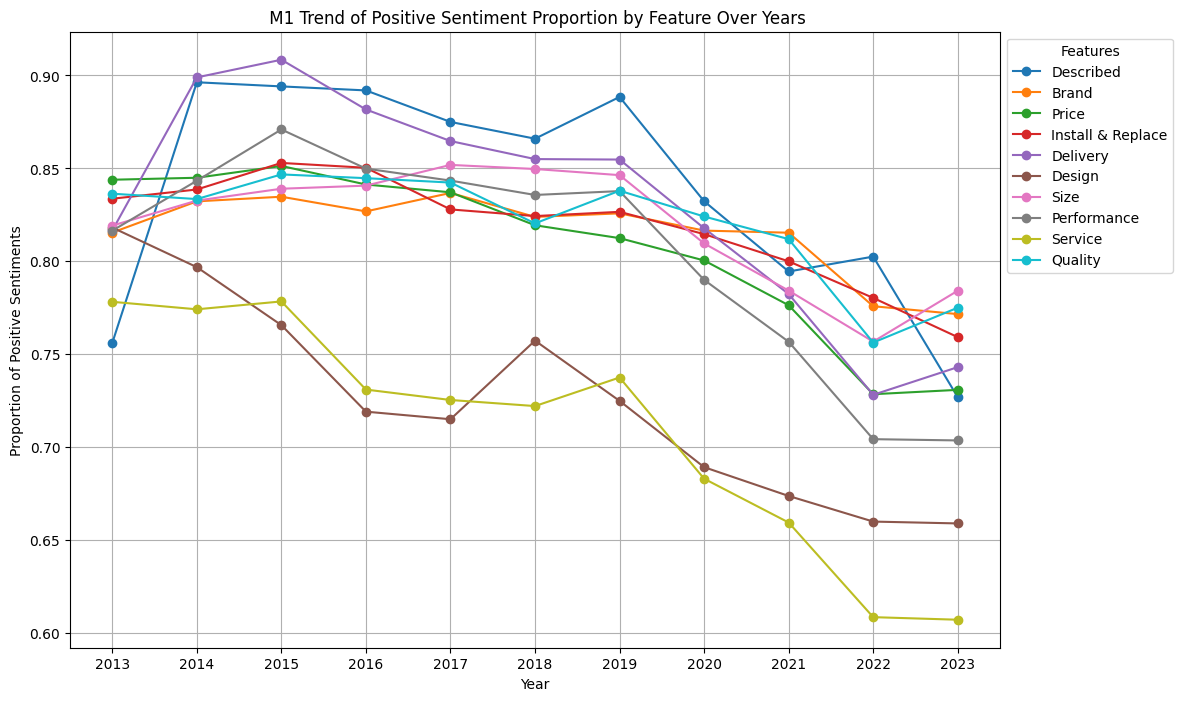

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

for feature in bab_data.index:
    ax.plot(bab_data.columns, bab_data.loc[feature], marker='o', label=feature)

ax.set_xlabel('Year')
ax.set_ylabel('Proportion of Positive Sentiments')
ax.set_title(' M1 Trend of Positive Sentiment Proportion by Feature Over Years')
ax.grid(True)
# Place the legend outside the plot area on the right side
ax.legend(title='Features', loc='upper left', bbox_to_anchor=(1,1))
plt.xticks(bab_data.columns)  # Ensure x-axis has the correct year labels
plt.show()

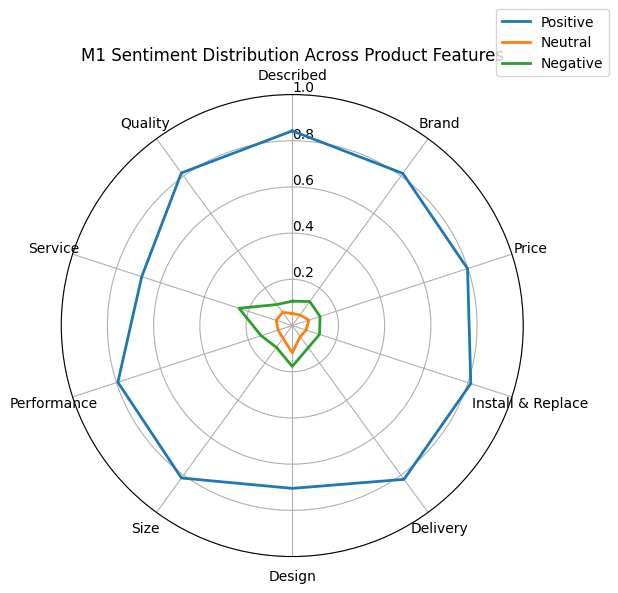

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from math import pi



# Clean data
df_all['Sentiment Polarity'] = df_all['Sentiment Polarity'].str.strip()
df_all['Stars'] = df_all['Stars'].str.strip()
df_all['Sentiment Score'] = df_all['Sentiment Score'].astype(float)
df_all['Characteristic Score'] = df_all['Characteristic Score'].astype(float)
df_all['Characteristic'] = df_all['Characteristic'].str.strip()

# List
features = [
    'Described',
    'Brand',
    'Price',
    'Install & Replace',
    'Delivery',
    'Design',
    'Size',
    'Performance',
    'Service',
    'Quality'
]


angles = [n / float(len(features)) * 2 * pi for n in range(len(features))]
angles += angles[:1] 

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))


for sentiment in ['positive', 'neutral', 'negative']:
    values = []
    for feature in features:
        subset = df_all[df_all['Characteristic'] == feature]
        sentiment_count = subset['Sentiment Polarity'].value_counts(normalize=True).get(sentiment, 0)
        values.append(sentiment_count)
    values += values[:1]
    ax.plot(angles, values, label=sentiment.capitalize(), linewidth=2)

# Plot
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids([a * 180 / pi for a in angles[:-1]], labels=features)
ax.set_rlabel_position(0)
ax.set_ylim(0, 1)
plt.title('M1 Sentiment Distribution Across Product Features')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
ls